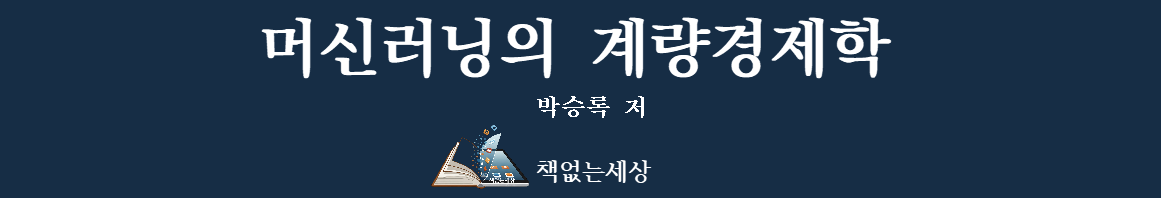

# Part 7: 시계열 분석법  

## Chapter 5: ARCH 모형과 GARCH 모형

In [2]:
# 작업공간(working directory)지정  
import os  
os.chdir("E:/JupyterWDirectory/MyStock")
os.getcwd()

'E:\\JupyterWDirectory\\MyStock'

In [34]:
# 본서에서 사용되는 모든 Library 불러오기 
exec(open('Functions/Traditional_Econometrics_Lib.py').read())

In [ ]:
"""
# #####################################################################
# 위의 함수는 아래 다양한 라이브러리와 함수를 한 문장으로 불러오는 방법
# #####################################################################

# 분석에 사용될 라이브러리(Libraries for the Analysis) 불러오기
# Libraries for the Analysis of Traditional Econometrics.py
# 불러오는 방법:  "exec(open('Functions/Traditional_Econometrics_Lib.py').read())"
# #####################################################################

# 만약 특정 라이브러리가 설치되지 않았다는 에러 메시지가 나타날 때는 
# 해당 라이브러리를 설치하여야 함
# 아래 라이브러리를 하나 하나 실행하면서 어떤 라이브러리가 설치되지 않았는지 확인하여도 됨
# #####################################################################
import os
import numpy as np                                       # Numerical calculations
import pandas as pd                                      # Data handling
import math as someAlias
import matplotlib.dates as mdates                        # Turn dates into numbers
import matplotlib.pyplot as plt                          # Lower-level graphics
import patsy as pt
import seaborn as sns
import stargazer.stargazer as sg
import statsmodels.api as sm
import statsmodels.formula.api as smf                    # Econometrics
import statsmodels.stats.api as sms
import statsmodels.stats.diagnostic as dg
import statsmodels.stats.outliers_influence as smo
import linearmodels as lm                                # Panel model, Simultaneous Eq. Model
import scipy.stats as stats                              # Statistics
import random

from scipy.optimize import Bounds
from scipy.optimize import curve_fit                    # Nonlinear regression
from scipy.optimize import minimize
from scipy.stats import norm
from statsmodels.graphics import tsaplots               # Time series
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.api import VAR
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller          # ADF test
from statsmodels.tsa.stattools import coint             # Cointegration
from statsmodels.tsa.vector_ar.vecm import VECM
from arch import arch_model

import wooldridge as woo
from imfpy.retrievals import dots
import wbdata
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")
"""\

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm  
from scipy import stats
import arch
import pandas_datareader as pdr
from datetime import datetime
import warnings  
%matplotlib inline  

#Ignoring the warnings  
warnings.filterwarnings("ignore")  

In [15]:
import matplotlib as mpl
mpl.rc('font', family='NanumGothic')
mpl.rc('axes', unicode_minus=False)

# Kospi, snp500, nasdaq 일별지수
data = pd.read_excel('Data/stockprice.xlsx', index_col='period', parse_dates=True)
data

,kospi,snp500,nasdaq
period,,,
2010-01-04,1696.1400,1132.990000,2308.419900
2010-01-05,1690.6200,1136.520000,2308.710000
2010-01-06,1705.3199,1137.140000,2301.090100
2010-01-07,1683.4500,1141.689900,2300.050000
2010-01-08,1695.2600,1144.980000,2317.169900
...,...,...,...
2025-07-18,3188.0701,6296.790000,20895.650000
2025-07-21,3210.8101,6305.600100,20974.180000
2025-07-22,3169.9399,6309.620100,20892.689000


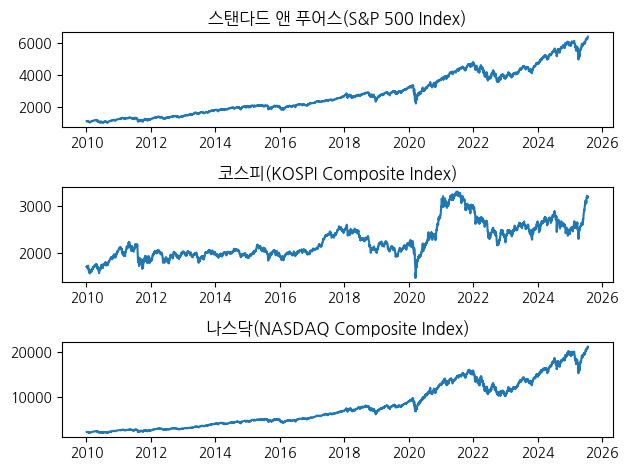

In [16]:
# 주가지수 그래프 그리기
fig, ax = plt.subplots(3, 1)  
ax = np.ravel(ax)  
ax[0].plot(data['snp500'])  
ax[1].plot(data['kospi'])   
ax[2].plot(data['nasdaq']) 
ax[0].set_title('스탠다드 앤 푸어스(S&P 500 Index)')  
ax[1].set_title('코스피(KOSPI Composite Index)')  
ax[2].set_title('나스닥(NASDAQ Composite Index)')  
fig.tight_layout()
plt.show() 

In [17]:
# 일별자료로 수익률 계산
returns = data.pct_change().dropna() * 100  
display(returns) 


,kospi,snp500,nasdaq
period,,,
2010-01-05,-0.325445,0.311565,0.012567
2010-01-06,0.869498,0.054552,-0.330050
2010-01-07,-1.282451,0.400118,-0.045200
2010-01-08,0.701536,0.288178,0.744327
2010-01-11,-0.067246,0.174676,-0.205423
...,...,...,...
2025-07-18,-0.132190,-0.009050,0.047880
2025-07-21,0.713284,0.139914,0.375820
2025-07-22,-1.272894,0.063753,-0.388530


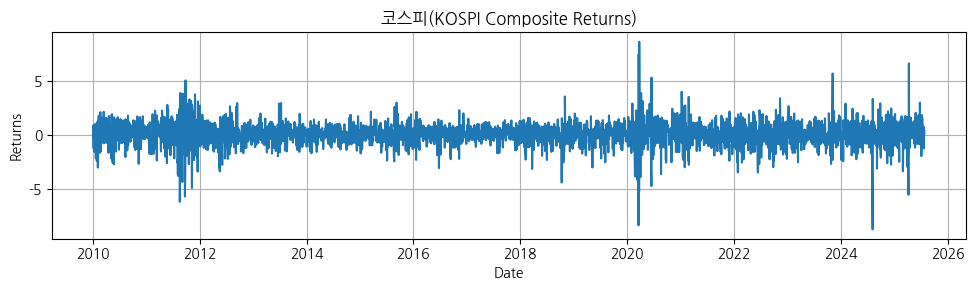

In [18]:
# 주가지수 수익률 그래프 그리기
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(returns['kospi'])
ax.set_title('코스피(KOSPI Composite Returns)')
ax.set_ylabel('Returns')
ax.set_xlabel('Date')
ax.grid(True)
plt.tight_layout()
plt.show()


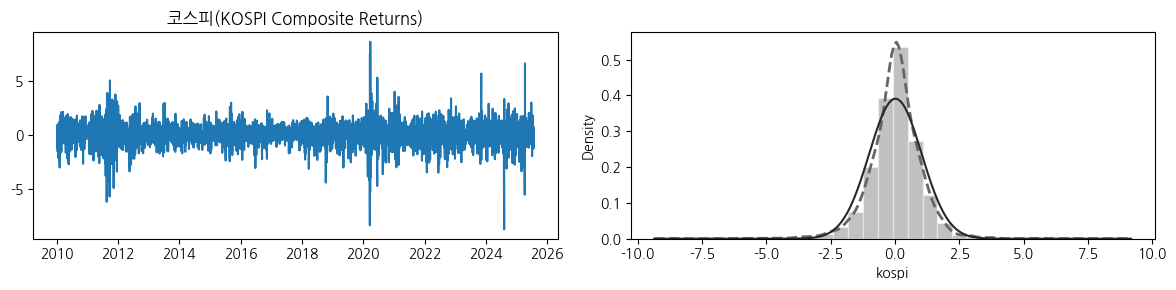

In [21]:
# 주가지수 수익률 및 변동성 그래프 그리기
fig, ax = plt.subplots(1, 2, figsize=(12,3))  
ax[0].set_title('코스피(KOSPI Composite Returns)')  
ax[0].plot(returns['kospi']) 
sns.distplot(returns['kospi'], ax=ax[1], hist=True, kde=True, fit=stats.norm, bins=30,
           color='0.4', hist_kws={'edgecolor':'white'},
           kde_kws={'linewidth': 2, 'linestyle': '--'})
fig.tight_layout()
plt.show() 

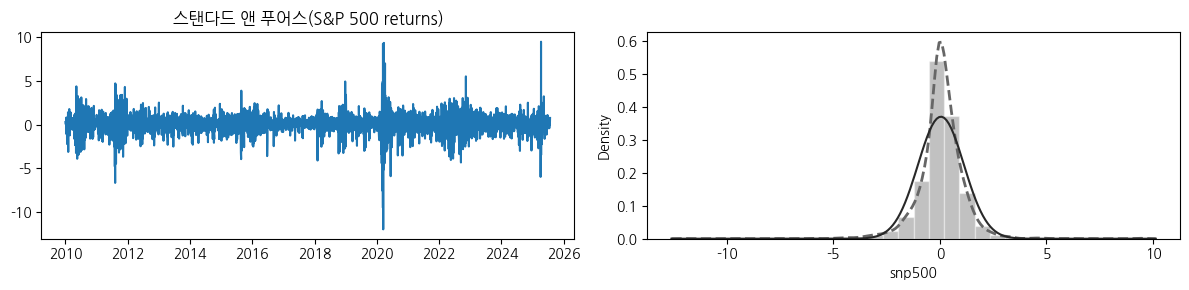

In [22]:
# 주가지수 수익률 및 변동성 그래프 그리기
fig, ax = plt.subplots(1, 2, figsize=(12,3))  
ax[0].set_title('스탠다드 앤 푸어스(S&P 500 returns)')  
ax[0].plot(returns['snp500']) 
sns.distplot(returns['snp500'], ax=ax[1], hist=True, kde=True, fit=stats.norm, bins=30,
           color='0.4', hist_kws={'edgecolor':'white'},
           kde_kws={'linewidth': 2, 'linestyle': '--'})
fig.tight_layout()
plt.show() 

### 라. ARCH 모형의 추정

In [26]:
# ARCH(1) volatility의 AR(1) 모형 추정 
y = returns['kospi']  
x = returns['snp500']
model = arch.arch_model(y=y,x=x, mean='ARX', vol='arch', p=1)  
res = model.fit(disp='off')  
print(res.summary()) 

res.arch_lm_test(lags=1, standardized= False)

                          AR-X - ARCH Model Results                           
Dep. Variable:                  kospi   R-squared:                       0.046
Mean Model:                      AR-X   Adj. R-squared:                  0.046
Vol Model:                       ARCH   Log-Likelihood:               -5444.12
Distribution:                  Normal   AIC:                           10896.2
Method:            Maximum Likelihood   BIC:                           10921.5
                                        No. Observations:                 4034
Date:                Thu, Jul 24 2025   Df Residuals:                     4032
Time:                        18:10:36   Df Model:                            2
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          0.0184  1.471e-02      1.254      0.210 

ARCH-LM Test
H0: Residuals are homoskedastic.
ARCH-LM Test
H1: Residuals are conditionally heteroskedastic.
Statistic: 618.6265
P-value: 0.0000
Distributed: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001D2B4004A40>
WaldTestStatistic, id: 0x1d2b4005280

In [28]:
# ARCH(4) volatility의 AR(4) 모형 추정 

y = returns['kospi']  
x = returns['snp500']
model = arch.arch_model(y=y, x=x, mean='ARX', vol='arch', p=4)  
res = model.fit(disp='off')  
print(res.summary()) 

res.arch_lm_test(lags=4, standardized= False)

                          AR-X - ARCH Model Results                           
Dep. Variable:                  kospi   R-squared:                       0.046
Mean Model:                      AR-X   Adj. R-squared:                  0.046
Vol Model:                       ARCH   Log-Likelihood:               -5320.49
Distribution:                  Normal   AIC:                           10655.0
Method:            Maximum Likelihood   BIC:                           10699.1
                                        No. Observations:                 4034
Date:                Thu, Jul 24 2025   Df Residuals:                     4032
Time:                        18:11:54   Df Model:                            2
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          0.0260  1.400e-02      1.858  6.323e-02 

ARCH-LM Test
H0: Residuals are homoskedastic.
ARCH-LM Test
H1: Residuals are conditionally heteroskedastic.
Statistic: 776.5492
P-value: 0.0000
Distributed: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001D2B40061E0>
WaldTestStatistic, id: 0x1d2b091ebd0

### 마. ARCH 모형에서 변동성의 예측

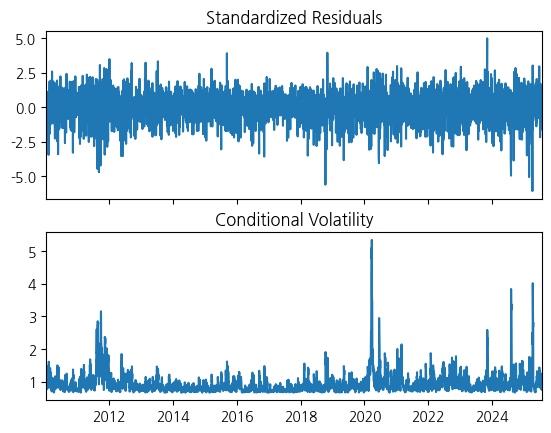

In [29]:
# standardized residuals와 conditional volatility 그리기
fig = res.plot() 

## 3. GARCH Model

In [30]:
# 코스피 지수에 대한 GARCH(1,1) volatility인 AR(1) 모형 추정
model = arch.arch_model(y=y, mean='AR', lags=[1], vol='garch', p=1, q=1)  
res = model.fit(disp='off')  
print(res.summary()) 

                           AR - GARCH Model Results                           
Dep. Variable:                  kospi   R-squared:                      -0.000
Mean Model:                        AR   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -5302.72
Distribution:                  Normal   AIC:                           10615.4
Method:            Maximum Likelihood   BIC:                           10646.9
                                        No. Observations:                 4033
Date:                Thu, Jul 24 2025   Df Residuals:                     4031
Time:                        18:18:42   Df Model:                            2
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          0.0384  1.348e-02      2.848  4.406e-03 

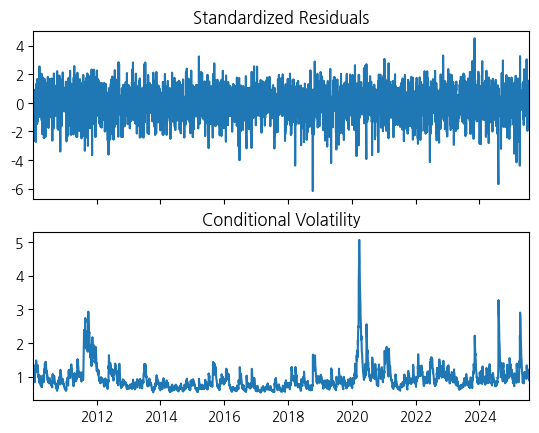

In [31]:
# GARCH 모형에서 변동성의 예측
fig = res.plot() 

### 다. GARCH 모형의 확장
#### 1) GARCH-M 모형

In [35]:
am = arch_model(y=y, x=x, mean='ARX', p=1, o=1, q=1)
res = am.fit()
print(res.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: 41296.626410556506
Iteration:      2,   Func. Count:     20,   Neg. LLF: 375216.2366681532
Iteration:      3,   Func. Count:     31,   Neg. LLF: 54647.20217900766
Iteration:      4,   Func. Count:     41,   Neg. LLF: 13041.078800863545
Iteration:      5,   Func. Count:     50,   Neg. LLF: 6700.771195911479
Iteration:      6,   Func. Count:     59,   Neg. LLF: 5214.7125803119
Iteration:      7,   Func. Count:     67,   Neg. LLF: 5406.560769715517
Iteration:      8,   Func. Count:     76,   Neg. LLF: 5203.780254987083
Iteration:      9,   Func. Count:     84,   Neg. LLF: 5204.045756500372
Iteration:     10,   Func. Count:     92,   Neg. LLF: 5203.395227357731
Iteration:     11,   Func. Count:     99,   Neg. LLF: 5203.395214787743
Iteration:     12,   Func. Count:    106,   Neg. LLF: 5203.395213584134
Iteration:     13,   Func. Count:    112,   Neg. LLF: 5203.395213583208
Optimization terminated successfully    (Exit mode 0)
          

#### 2) TGARCH 모형

In [36]:
am = arch_model(y=y, x=x, mean='ARX', p=1, o=1, q=1, power=1.0)
res = am.fit()
print(res.summary())


Iteration:      1,   Func. Count:      8,   Neg. LLF: 473672.51444312045
Iteration:      2,   Func. Count:     19,   Neg. LLF: 84855.63936708492
Iteration:      3,   Func. Count:     29,   Neg. LLF: 225568.90693763376
Iteration:      4,   Func. Count:     41,   Neg. LLF: 22848.43570289535
Iteration:      5,   Func. Count:     50,   Neg. LLF: 6895.212409225372
Iteration:      6,   Func. Count:     59,   Neg. LLF: 5214.70576012609
Iteration:      7,   Func. Count:     66,   Neg. LLF: 5302.688601717198
Iteration:      8,   Func. Count:     74,   Neg. LLF: 5518.516204116009
Iteration:      9,   Func. Count:     84,   Neg. LLF: 5239.830288580689
Iteration:     10,   Func. Count:     92,   Neg. LLF: 5191.84669756903
Iteration:     11,   Func. Count:     99,   Neg. LLF: 5191.842481840302
Iteration:     12,   Func. Count:    107,   Neg. LLF: 5191.385239750409
Iteration:     13,   Func. Count:    114,   Neg. LLF: 5191.363198289417
Iteration:     14,   Func. Count:    121,   Neg. LLF: 5191.36289

#### 3) EGARCH 모형

In [37]:
am = arch_model(y=y, x=x, mean='ARX', vol='egarch', p=1, o=1, q=1)
res = am.fit()
print(res.summary())


Iteration:      1,   Func. Count:      8,   Neg. LLF: 12863646865279.998
Iteration:      2,   Func. Count:     20,   Neg. LLF: 49319440068196.65
Iteration:      3,   Func. Count:     31,   Neg. LLF: 37858715798689.13
Iteration:      4,   Func. Count:     42,   Neg. LLF: 2385538493457.3013
Iteration:      5,   Func. Count:     53,   Neg. LLF: 33491702.925814368
Iteration:      6,   Func. Count:     63,   Neg. LLF: 13027.861511901498
Iteration:      7,   Func. Count:     72,   Neg. LLF: 5191.26721205124
Iteration:      8,   Func. Count:     79,   Neg. LLF: 5191.105192249203
Iteration:      9,   Func. Count:     86,   Neg. LLF: 5190.923831553622
Iteration:     10,   Func. Count:     93,   Neg. LLF: 5190.919718991503
Iteration:     11,   Func. Count:    100,   Neg. LLF: 5190.918564104562
Iteration:     12,   Func. Count:    107,   Neg. LLF: 5190.918480403216
Iteration:     13,   Func. Count:    114,   Neg. LLF: 5190.918475703157
Iteration:     14,   Func. Count:    121,   Neg. LLF: 5190.91